# Riss 'rare diseases' 학술정보 스크래핑 data
- 방법 1) 주제어 뽑아서 topic 분류 후 지도학습 / 의미있는 topic분류가 안된다면
- 방법 2) 수동 분류 index 부여해서 지도학습

In [183]:
import pandas as pd
import numpy as np

In [184]:
df_Riss_research = pd.read_csv("./csv/Seleniums.eng_academic_research2.csv")
df_Riss_research.drop(labels='_id', axis=1, inplace=True)
df_Riss_research

,research_title,research_url,research_author,research_institution,research_name,research_volumn,research_year,research_language,research_subject,research_type,research_page
0,Collaboration through the Asia Pacific MPS Net...,https://www.riss.kr/link?id=A102412091,"Cho, Sung Yoon",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,Mucopolysaccharidosis ; Rare diseases ; APMN...,학술저널,
1,Journal of Mucopolysaccharidosis and Rare Dise...,https://www.riss.kr/link?id=A102412090,"Jin, Dong-Kyu",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,,학술저널,
2,Rare Presentation of an Uncommon Disease = Rar...,https://www.riss.kr/link?id=A108105268,( Vikas Marwah ) ; ( Shrinath Vasudevan ) ; ...,대한결핵 및 호흡기학회,Tuberculosis and Respiratory Diseases,Vol.85 No.2 [2022],2022,-,,학술저널,
3,Newborn Screening for Lysosomal Storage Diseas...,https://www.riss.kr/link?id=A103296772,"Lin, Hsiang-Yu ; Chuang, Chih-Kuang ; Lin, S...",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Enzyme replacement therapy ; Fluorimetry ; H...,학술저널,
4,Newborn Screening of Lysosomal Storage Disease...,https://www.riss.kr/link?id=A103296779,"Kim, Su Jin",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Newborn screening ; Lysosomal storage disease...,학술저널,
...,...,...,...,...,...,...,...,...,...,...,...
14656,종례 : 만성내장질환 환자에서 발생한 십이지장 및 공장의 허혈성 장염 1예 = Ca...,https://www.riss.kr/link?id=A60094700,김건민 ( Gun Min Kim ) ; 김용철 ( Yong Cheol Kim ) ...,대한내과학회,대한내과학회지 (The Korean Journal of Medicine),Vol.82 No.6 [2012],2012,-,내장순환 ; 허혈 ; 십이지장염 Splanchnic circulation ; ...,학술저널,
14657,Non-Tuberculous Mycobacterium Induced Pseudoan...,https://www.riss.kr/link?id=A103555339,이해영 (고신대학교) ; 조성호 (고신대학교) ; 김현수 (고신대학교 의과대학 ...,대한흉부외과학회,Journal of Chest Surgery (J Chest Surg)(The Ko...,Vol.49 No.6 [2016],2016,English,1. Carotid arteries 2. Infection 3. Nontubercu...,학술저널,
14658,장기간 항갑상선제 투여 후 임의 중단 뒤 재복용시 발생한 무과립구증 1 예 = A ...,https://www.riss.kr/link?id=A99535412,김승만;김태영;박수영;배영환;서영경 정은주;김태균;권민정;박정현;이순희 (인제대학교...,인제대학교,仁濟醫學(Inje medical journal),Vol.32 No.- [2011],2011,Korean,Agranulocytosis ; Antithyroid agents,학술저널,
14659,HCC : PE-073 ; Synchronous development of intr...,https://www.riss.kr/link?id=A100021711,( Kyung Hyun Cheon ) ; ( Kyu Sik Jung ) ; ( ...,대한간학회(The Korean Association for the Study of ...,춘·추계 학술대회 (KASL)(N/A),Vol.2012 No.1 [2012],2012,Korean,Hepatocellular carcinoma ; Intrahepatic chola...,학술저널,


# 주제어 뽑아서 topic 분류 후 지도학습

## 데이터 전처리

### dataframe 내 중복되는 학술정보 제거

In [185]:
df_Riss_research['research_title'].value_counts()

research_title
Clinical characterization of a Korean case with 3p25 deletion                                                         4
Diagnostic Tools of Pleural Effusion                                                                                  3
Identification of a novel frameshift mutation (L345Sfs*15) in a Korean neonate with methylmalonic acidemia            3
Squamous cell carcinoma of the maxillary sinus mimicking periodontitis                                                3
戶名을 통해 본 19세기 職役과 率下奴婢 = Occupations and Domestic Slaves Seen through the Practice of household title                 3
                                                                                                                     ..
비특이적 슬관절 활액막염에 의한 다발성 미립체 = A Case of Multiple Rice Bodies by the Nonspecific Synovitis in the Knee Joint             1
췌장에 전이된 폐 소세포암 = Metastatic Small Cell Carcinoma of the Pancreas Originating from the Lung                            1
스티븐스존슨증후군의 형태로 발생한 전신홍반루푸

In [186]:
df_Riss_research.drop_duplicates(subset="research_title", keep='first', inplace=True)
df_Riss_research['research_title'].value_counts()
# 중복값 제거 완료 확인

research_title
팬데믹 상황에서의 관계적 돌봄: 파킨슨증 아버지의 돌봄 사례를 중심으로                                                                                                                                                                                                                                                                                1
Collaboration through the Asia Pacific MPS Network (APMN), Asia Pacific MPS Registry (APMR), and Association for Research of MPS & Rare Diseases (ARMRD) = Collaboration through the Asia Pacific MPS Network (APMN), Asia Pacific MPS Registry (APMR), and Association for Research of MPS & Rare Diseases (ARMRD)    1
Journal of Mucopolysaccharidosis and Rare Diseases: Launch Editorial                                                                                                                                                                                                                                                   1
Rare Presentation of an Uncommon Disease = Rar

In [187]:
df_Riss_research.reset_index(drop=True, inplace=True)

### 영문 text만 남기기

In [188]:
import re
def no_space(text):
    patterns = '([가-힣] |[;]  |[0-9]. |[一-龥]\?|[一-龥] |[あ-ん]|[一-龥] |[一-龥]\? )'
    text_regex = re.sub(pattern=patterns, repl="", string=text)
    return text_regex
df_Riss_research['research_subject'] = df_Riss_research['research_subject'].apply(no_space)
df_Riss_research['research_subject'][1]

<>:3: DeprecationWarning: invalid escape sequence '\?'
<>:3: DeprecationWarning: invalid escape sequence '\?'
/tmp/ipykernel_79844/4248931307.py:3: DeprecationWarning: invalid escape sequence '\?'
  patterns = '([가-힣] |[;]  |[0-9]. |[一-龥]\?|[一-龥] |[あ-ん]|[一-龥] |[一-龥]\? )'


' '

In [189]:
def no_korean(text):
    patterns = '([가-힣]|[一-龥]|[0-9]|[;]|  )'
    text_regex = re.sub(pattern=patterns, repl='', string=text)
    return text_regex
df_Riss_research['research_subject'] = df_Riss_research['research_subject'].apply(no_korean)
df_Riss_research

,research_title,research_url,research_author,research_institution,research_name,research_volumn,research_year,research_language,research_subject,research_type,research_page
0,Collaboration through the Asia Pacific MPS Net...,https://www.riss.kr/link?id=A102412091,"Cho, Sung Yoon",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,Mucopolysaccharidosis Rare diseases APMN APMR ...,학술저널,
1,Journal of Mucopolysaccharidosis and Rare Dise...,https://www.riss.kr/link?id=A102412090,"Jin, Dong-Kyu",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,,학술저널,
2,Rare Presentation of an Uncommon Disease = Rar...,https://www.riss.kr/link?id=A108105268,( Vikas Marwah ) ; ( Shrinath Vasudevan ) ; ...,대한결핵 및 호흡기학회,Tuberculosis and Respiratory Diseases,Vol.85 No.2 [2022],2022,-,,학술저널,
3,Newborn Screening for Lysosomal Storage Diseas...,https://www.riss.kr/link?id=A103296772,"Lin, Hsiang-Yu ; Chuang, Chih-Kuang ; Lin, S...",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Enzyme replacement therapy Fluorimetry Hematop...,학술저널,
4,Newborn Screening of Lysosomal Storage Disease...,https://www.riss.kr/link?id=A103296779,"Kim, Su Jin",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Newborn screening Lysosomal storage disease Mu...,학술저널,
...,...,...,...,...,...,...,...,...,...,...,...
14133,HCC : PE-073 ; Synchronous development of intr...,https://www.riss.kr/link?id=A99702227,( Kyung Hyun Cheon ) ; ( Kyu Sik Jung ) ; ( ...,대한간학회(The Korean Association for the Study of ...,춘·추계 학술대회 (KASL)(N/A),Vol.2012 No.- [2012],2012,Korean,Hepatocellular carcinoma Intrahepatic cholangi...,학술저널,
14134,종례 : 만성내장질환 환자에서 발생한 십이지장 및 공장의 허혈성 장염 1예 = Ca...,https://www.riss.kr/link?id=A60094700,김건민 ( Gun Min Kim ) ; 김용철 ( Yong Cheol Kim ) ...,대한내과학회,대한내과학회지 (The Korean Journal of Medicine),Vol.82 No.6 [2012],2012,-,Splanchnic circulation Ischemia Duodenitis,학술저널,
14135,Non-Tuberculous Mycobacterium Induced Pseudoan...,https://www.riss.kr/link?id=A103555339,이해영 (고신대학교) ; 조성호 (고신대학교) ; 김현수 (고신대학교 의과대학 ...,대한흉부외과학회,Journal of Chest Surgery (J Chest Surg)(The Ko...,Vol.49 No.6 [2016],2016,English,Carotid arteries Infection Nontuberculous myco...,학술저널,
14136,장기간 항갑상선제 투여 후 임의 중단 뒤 재복용시 발생한 무과립구증 1 예 = A ...,https://www.riss.kr/link?id=A99535412,김승만;김태영;박수영;배영환;서영경 정은주;김태균;권민정;박정현;이순희 (인제대학교...,인제대학교,仁濟醫學(Inje medical journal),Vol.32 No.- [2011],2011,Korean,Agranulocytosis Antithyroid agents,학술저널,


In [190]:
def no_space_no(text):
    if text == ' ' :
        return None
    else :
        return text
df_Riss_research['research_subject'] = df_Riss_research['research_subject'].apply(no_space_no)
df_Riss_research

,research_title,research_url,research_author,research_institution,research_name,research_volumn,research_year,research_language,research_subject,research_type,research_page
0,Collaboration through the Asia Pacific MPS Net...,https://www.riss.kr/link?id=A102412091,"Cho, Sung Yoon",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,Mucopolysaccharidosis Rare diseases APMN APMR ...,학술저널,
1,Journal of Mucopolysaccharidosis and Rare Dise...,https://www.riss.kr/link?id=A102412090,"Jin, Dong-Kyu",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,None,학술저널,
2,Rare Presentation of an Uncommon Disease = Rar...,https://www.riss.kr/link?id=A108105268,( Vikas Marwah ) ; ( Shrinath Vasudevan ) ; ...,대한결핵 및 호흡기학회,Tuberculosis and Respiratory Diseases,Vol.85 No.2 [2022],2022,-,None,학술저널,
3,Newborn Screening for Lysosomal Storage Diseas...,https://www.riss.kr/link?id=A103296772,"Lin, Hsiang-Yu ; Chuang, Chih-Kuang ; Lin, S...",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Enzyme replacement therapy Fluorimetry Hematop...,학술저널,
4,Newborn Screening of Lysosomal Storage Disease...,https://www.riss.kr/link?id=A103296779,"Kim, Su Jin",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Newborn screening Lysosomal storage disease Mu...,학술저널,
...,...,...,...,...,...,...,...,...,...,...,...
14133,HCC : PE-073 ; Synchronous development of intr...,https://www.riss.kr/link?id=A99702227,( Kyung Hyun Cheon ) ; ( Kyu Sik Jung ) ; ( ...,대한간학회(The Korean Association for the Study of ...,춘·추계 학술대회 (KASL)(N/A),Vol.2012 No.- [2012],2012,Korean,Hepatocellular carcinoma Intrahepatic cholangi...,학술저널,
14134,종례 : 만성내장질환 환자에서 발생한 십이지장 및 공장의 허혈성 장염 1예 = Ca...,https://www.riss.kr/link?id=A60094700,김건민 ( Gun Min Kim ) ; 김용철 ( Yong Cheol Kim ) ...,대한내과학회,대한내과학회지 (The Korean Journal of Medicine),Vol.82 No.6 [2012],2012,-,Splanchnic circulation Ischemia Duodenitis,학술저널,
14135,Non-Tuberculous Mycobacterium Induced Pseudoan...,https://www.riss.kr/link?id=A103555339,이해영 (고신대학교) ; 조성호 (고신대학교) ; 김현수 (고신대학교 의과대학 ...,대한흉부외과학회,Journal of Chest Surgery (J Chest Surg)(The Ko...,Vol.49 No.6 [2016],2016,English,Carotid arteries Infection Nontuberculous myco...,학술저널,
14136,장기간 항갑상선제 투여 후 임의 중단 뒤 재복용시 발생한 무과립구증 1 예 = A ...,https://www.riss.kr/link?id=A99535412,김승만;김태영;박수영;배영환;서영경 정은주;김태균;권민정;박정현;이순희 (인제대학교...,인제대학교,仁濟醫學(Inje medical journal),Vol.32 No.- [2011],2011,Korean,Agranulocytosis Antithyroid agents,학술저널,


In [191]:
df_Riss_research.dropna(inplace=True)
df_Riss_research.reset_index(drop=True, inplace=True)
df_Riss_research

,research_title,research_url,research_author,research_institution,research_name,research_volumn,research_year,research_language,research_subject,research_type,research_page
0,Collaboration through the Asia Pacific MPS Net...,https://www.riss.kr/link?id=A102412091,"Cho, Sung Yoon",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,Mucopolysaccharidosis Rare diseases APMN APMR ...,학술저널,
1,Newborn Screening for Lysosomal Storage Diseas...,https://www.riss.kr/link?id=A103296772,"Lin, Hsiang-Yu ; Chuang, Chih-Kuang ; Lin, S...",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Enzyme replacement therapy Fluorimetry Hematop...,학술저널,
2,Newborn Screening of Lysosomal Storage Disease...,https://www.riss.kr/link?id=A103296779,"Kim, Su Jin",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Newborn screening Lysosomal storage disease Mu...,학술저널,
3,Skin Models to Study Common and Rare Diseases ...,https://www.riss.kr/link?id=A100298513,( John E Acommon ) ; ( Christabelle S M Goh )...,한국피부장벽학회(N/A),한국피부장벽학회지(The Journal of Skin Barrier Research),Vol.16 No.2 [2014],2014,-,Skin barrier Filaggrin Atopic dermatitis Epide...,학술저널,
4,New Era of Management Concept on Pulmonary Fib...,https://www.riss.kr/link?id=A106922368,( Arata Azuma ) (Nippon Medical School) ; ( L...,대한결핵 및 호흡기학회,Tuberculosis and Respiratory Diseases,Vol.83 No.3 [2020],2020,-,Idiopathic Pulmonary Fibrosis Interstitial Pne...,학술저널,
...,...,...,...,...,...,...,...,...,...,...,...
10801,HCC : PE-073 ; Synchronous development of intr...,https://www.riss.kr/link?id=A99702227,( Kyung Hyun Cheon ) ; ( Kyu Sik Jung ) ; ( ...,대한간학회(The Korean Association for the Study of ...,춘·추계 학술대회 (KASL)(N/A),Vol.2012 No.- [2012],2012,Korean,Hepatocellular carcinoma Intrahepatic cholangi...,학술저널,
10802,종례 : 만성내장질환 환자에서 발생한 십이지장 및 공장의 허혈성 장염 1예 = Ca...,https://www.riss.kr/link?id=A60094700,김건민 ( Gun Min Kim ) ; 김용철 ( Yong Cheol Kim ) ...,대한내과학회,대한내과학회지 (The Korean Journal of Medicine),Vol.82 No.6 [2012],2012,-,Splanchnic circulation Ischemia Duodenitis,학술저널,
10803,Non-Tuberculous Mycobacterium Induced Pseudoan...,https://www.riss.kr/link?id=A103555339,이해영 (고신대학교) ; 조성호 (고신대학교) ; 김현수 (고신대학교 의과대학 ...,대한흉부외과학회,Journal of Chest Surgery (J Chest Surg)(The Ko...,Vol.49 No.6 [2016],2016,English,Carotid arteries Infection Nontuberculous myco...,학술저널,
10804,장기간 항갑상선제 투여 후 임의 중단 뒤 재복용시 발생한 무과립구증 1 예 = A ...,https://www.riss.kr/link?id=A99535412,김승만;김태영;박수영;배영환;서영경 정은주;김태균;권민정;박정현;이순희 (인제대학교...,인제대학교,仁濟醫學(Inje medical journal),Vol.32 No.- [2011],2011,Korean,Agranulocytosis Antithyroid agents,학술저널,


### 대문자 -> 소문자

In [192]:
df_Riss_research['research_subject'] = df_Riss_research['research_subject'].str.lower()

### 불용어 제거

In [193]:
f=open('./csv/eng_academic_research_stopwords.txt')
stopwords=[]
lines = f.readlines()
for line in lines:
    line = line.strip()
    stopwords.append(line)
f.close()

### Tfidfvectorizer

In [194]:
eng_subject = df_Riss_research['research_subject'].tolist()
eng_subject = ' '.join(eng_subject).split()
eng_subject

['mucopolysaccharidosis',
 'rare',
 'diseases',
 'apmn',
 'apmr',
 'armrd',
 'enzyme',
 'replacement',
 'therapy',
 'fluorimetry',
 'hematopoietic',
 'stem',
 'cell',
 'transplantation',
 'lysosomal',
 'storage',
 'disease',
 'newborn',
 'screening',
 'tandem',
 'mass',
 'spectrometry',
 'newborn',
 'screening',
 'lysosomal',
 'storage',
 'disease',
 'mucopolysacchariodis',
 'skin',
 'barrier',
 'filaggrin',
 'atopic',
 'dermatitis',
 'epidermolysis',
 'bullosa',
 'keratin',
 'genodermatoses',
 'idiopathic',
 'pulmonary',
 'fibrosis',
 'interstitial',
 'pneumonia',
 'pathological',
 'phenotype',
 'progressive',
 'fibrosis',
 'adenocarcinoma',
 'thymus',
 'concurrent',
 'chemoradiotherapies',
 'solitary',
 'fibrous',
 'tumors',
 'pleura',
 'lipoma',
 'bronchial',
 'neoplasms',
 'carcinoma',
 'lung',
 'peritoneal',
 'dialysis',
 'pleuroperitoneal',
 'communication',
 'peritoneography',
 'pleural',
 'effusion',
 'pd',
 'catheter',
 'mucopolysaccharidoses',
 'enzyme',
 'replacement',
 'the

In [356]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(stop_words=stopwords
                                  , ngram_range=(1,2)
                                  , max_df=0.80
                                  , min_df=10) 
result_vectors = tfidfVectorizer.fit_transform(eng_subject)
result_vectors.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [357]:
tfidfVectorizer.vocabulary_ 

{'mucopolysaccharidosis': 822,
 'enzyme': 409,
 'replacement': 1102,
 'hematopoietic': 543,
 'stem': 1203,
 'cell': 202,
 'transplantation': 1293,
 'lysosomal': 757,
 'storage': 1215,
 'newborn': 889,
 'screening': 1143,
 'mass': 776,
 'skin': 1179,
 'atopic': 115,
 'dermatitis': 326,
 'epidermolysis': 414,
 'bullosa': 172,
 'idiopathic': 604,
 'pulmonary': 1066,
 'fibrosis': 462,
 'interstitial': 657,
 'pneumonia': 1017,
 'phenotype': 998,
 'progressive': 1054,
 'adenocarcinoma': 18,
 'thymus': 1275,
 'solitary': 1187,
 'fibrous': 463,
 'tumors': 1309,
 'pleura': 1011,
 'lipoma': 728,
 'bronchial': 166,
 'neoplasms': 869,
 'carcinoma': 185,
 'lung': 741,
 'peritoneal': 989,
 'dialysis': 337,
 'pleural': 1012,
 'effusion': 384,
 'pd': 973,
 'catheter': 196,
 'intractable': 665,
 'social': 1184,
 'media': 781,
 'exome': 434,
 'sequencing': 1159,
 'whole': 1371,
 'genome': 503,
 'rna': 1122,
 'gene': 496,
 'gallbladder': 485,
 'tubular': 1307,
 'adenoma': 20,
 'papillary': 953,
 'neoplas

### K-means & Elbow method & prediction_strength 활용해서 최적 분류 수 찾기

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [359]:
# 클러스터 개수 범위 설정
min_clusters = 1
max_clusters = 10

In [360]:
# 각 클러스터 개수에 따른 SSE 값 저장
sse = []

In [361]:
# 클러스터링 수행 및 SSE 계산
for n_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(result_vectors)
    sse.append(kmeans.inertia_)

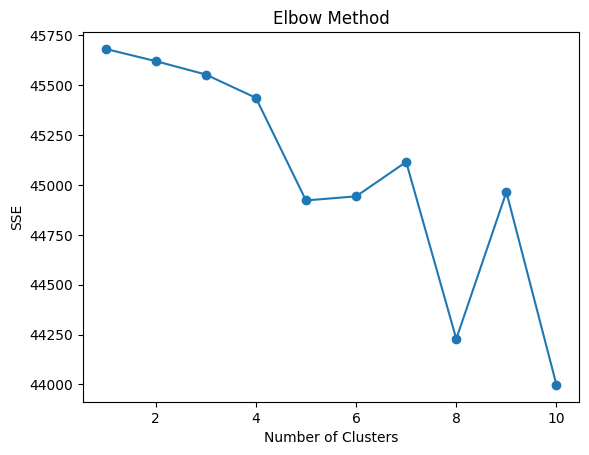

In [362]:
plt.plot(range(min_clusters, max_clusters+1), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()
# 유의미하지 않아 Prediction Strength로 최적군집수 재확인

In [363]:
from sklearn.metrics import pairwise_distances
from sklearn.utils import shuffle

In [364]:
def prediction_strength(X, n_clusters, n_runs=10):
    all_labels = []
    for _ in range(n_runs):
        # 데이터를 무작위로 섞음
        X_shuffled = shuffle(X, random_state=10)
        
        # K-means 클러스터링 실행
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(X_shuffled)
        all_labels.append(labels)
    
    all_labels = np.array(all_labels)
    pairwise_similarities = pairwise_distances(all_labels, metric='jaccard')
    prediction_strengths = pairwise_similarities.mean(axis=0)
    
    return prediction_strengths

# 데이터
X = result_vectors

# Prediction Strength 계산
n_clusters = 5
strengths = prediction_strength(X, n_clusters)
print(strengths)

# elbow method 기준 4, 6, 9 개가 유의미해서 prediction strength에서 비교해본 결과
# 4 = 0.89461003   / 6 = 0.29980147 / 9 = 0.29936111 
# 4개로 채택

[0.00265314 0.00237253 0.00442658 0.0091969  0.00278783 0.00252967
 0.00597553 0.00322558 0.00266437 0.00303477]


/usr/local/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### LDA : topic 모델링

In [365]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=4, n_jobs=-1, random_state=10) # Prediction Strength로 확인한 최적 군집수 = 4
lda_model.fit(result_vectors)

LatentDirichletAllocation(n_components=4, n_jobs=-1, random_state=10)

In [366]:
dictionary_list = tfidfVectorizer.get_feature_names_out()
dictionary_list

array(['abdomen', 'abdominal', 'abducens', ..., 'young', 'zone', 'zoster'],
      dtype=object)

In [369]:
lda_model.components_

array([[34.24925842,  0.2503065 ,  0.2502877 , ...,  0.25103919,
         0.25030657,  0.25172643],
       [ 0.25026417,  0.25029933, 11.0568906 , ...,  0.250305  ,
         0.2502994 ,  0.25051207],
       [ 0.25023965,  0.25027154,  0.25092874, ..., 28.76437071,
        22.24912456, 63.57246911],
       [ 0.25023777, 72.24912263,  0.25025288, ...,  0.25027451,
         0.25026947,  0.250282  ]])

In [370]:
topics_output = lda_model.transform(result_vectors)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score

,0,1,2,3
0,0.125010,0.125010,0.125009,0.624970
1,0.250000,0.250000,0.250000,0.250000
2,0.250000,0.250000,0.250000,0.250000
3,0.250000,0.250000,0.250000,0.250000
4,0.250000,0.250000,0.250000,0.250000
...,...,...,...,...
71269,0.250000,0.250000,0.250000,0.250000
71270,0.250000,0.250000,0.250000,0.250000
71271,0.125006,0.624982,0.125006,0.125006
71272,0.250000,0.250000,0.250000,0.250000


In [371]:
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1)
df_topics_score

,0,1,2,3,dominant_topic_number
0,0.125010,0.125010,0.125009,0.624970,3
1,0.250000,0.250000,0.250000,0.250000,0
2,0.250000,0.250000,0.250000,0.250000,0
3,0.250000,0.250000,0.250000,0.250000,0
4,0.250000,0.250000,0.250000,0.250000,0
...,...,...,...,...,...
71269,0.250000,0.250000,0.250000,0.250000,0
71270,0.250000,0.250000,0.250000,0.250000,0
71271,0.125006,0.624982,0.125006,0.125006,1
71272,0.250000,0.250000,0.250000,0.250000,0


In [372]:
df_topics_score.dropna(inplace=True)
df_topics_score

,0,1,2,3,dominant_topic_number
0,0.125010,0.125010,0.125009,0.624970,3
1,0.250000,0.250000,0.250000,0.250000,0
2,0.250000,0.250000,0.250000,0.250000,0
3,0.250000,0.250000,0.250000,0.250000,0
4,0.250000,0.250000,0.250000,0.250000,0
...,...,...,...,...,...
71269,0.250000,0.250000,0.250000,0.250000,0
71270,0.250000,0.250000,0.250000,0.250000,0
71271,0.125006,0.624982,0.125006,0.125006,1
71272,0.250000,0.250000,0.250000,0.250000,0


### topic별 word 추출

In [373]:
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)
    topics_text = ' '.join(df_topics[1].values[:10])
    print(topics_text)
    topics_list.append(topics_text)

topics_list_add = [['Topic0', 'Topic1', 'Topic2', 'Topic3'], topics_list]
df_topics_keywords = pd.DataFrame(topics_list_add)
df_topics_keywords = df_topics_keywords.T
df_topics_keywords

carcinoma cancer neoplasm metastasis congenital primary lupus transplantation computed child
neoplasms pulmonary chronic breast kidney resonance imaging fistula sinus drug
cell artery renal tomography thyroid abscess malignant hepatitis heart sarcoma
lung lymphoma tumor acute liver cyst tuberculosis infection surgery systemic


,0,1
0,Topic0,carcinoma cancer neoplasm metastasis congenita...
1,Topic1,neoplasms pulmonary chronic breast kidney reso...
2,Topic2,cell artery renal tomography thyroid abscess m...
3,Topic3,lung lymphoma tumor acute liver cyst tuberculo...


### LDA 시각화

In [374]:
import pyLDAvis
import pyLDAvis.lda_model

In [375]:
vis = pyLDAvis.lda_model.prepare(lda_model, result_vectors, tfidfVectorizer)

In [376]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### topic 분류별 data 수

In [377]:
pivot_table = pd.pivot_table(data=df_topics_score,
               values='research_subject',
               index='dominant_topic_number',
               aggfunc='count')

KeyError: 'research_subject'

In [378]:
pivot_table

,research_subject
dominant_topic_number,
0,5354
1,1682
2,1800
3,1970


In [379]:
index_0 = df_topics_score.query('dominant_topic_number==0').index
index_1 = df_topics_score.query('dominant_topic_number==1').index
index_2 = df_topics_score.query('dominant_topic_number==2').index
index_3 = df_topics_score.query('dominant_topic_number==3').index

In [380]:
for i in range(len(df_topics_score)):
    if i in index_0:    
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[0,1]
    elif i in index_1:
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[1,1]
    elif i in index_2:
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[2,1]
    elif i in index_3:
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[3,1]
df_topics_score

,0,1,2,3,dominant_topic_number,topic_keywords
0,0.125010,0.125010,0.125009,0.624970,3,lung lymphoma tumor acute liver cyst tuberculo...
1,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...
2,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...
3,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...
4,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...
...,...,...,...,...,...,...
71269,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...
71270,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...
71271,0.125006,0.624982,0.125006,0.125006,1,neoplasms pulmonary chronic breast kidney reso...
71272,0.250000,0.250000,0.250000,0.250000,0,carcinoma cancer neoplasm metastasis congenita...


#### topic0 : 

In [381]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==0")[:30]

KeyError: "['research_subject'] not in index"

#### topic1 : 

In [338]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==1")[:30]

,dominant_topic_number,research_subject,topic_keywords
6,1,solitary fibrous tumors pleura lipoma,neoplasms pulmonary chronic breast kidney reso...
11,1,rare diseases multi-omics exome sequencing who...,neoplasms pulmonary chronic breast kidney reso...
38,1,menkes disease hair x-linked copper metabolism...,neoplasms pulmonary chronic breast kidney reso...
41,1,bowen’s disease pigmented bowen’s disease,neoplasms pulmonary chronic breast kidney reso...
47,1,nontuberculous mycobacteria bronchiectasis myc...,neoplasms pulmonary chronic breast kidney reso...
51,1,mycobacterium infections nontuberculous mycoba...,neoplasms pulmonary chronic breast kidney reso...
54,1,immunoglobulin g autoimmune diseases pleural n...,neoplasms pulmonary chronic breast kidney reso...
55,1,mycobacterium kansasii pneumothorax,neoplasms pulmonary chronic breast kidney reso...
56,1,bronchiectasis mycobacterium infections nontub...,neoplasms pulmonary chronic breast kidney reso...
59,1,mps iiia mouse model phenotypic characterization,neoplasms pulmonary chronic breast kidney reso...


#### topic2 : 

In [339]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==2")[:30]

,dominant_topic_number,research_subject,topic_keywords
12,2,exome sequencing rare diseases gene discovery,cell artery renal tomography thyroid abscess m...
15,2,chip assembly etching fabrication leukemia sem...,cell artery renal tomography thyroid abscess m...
25,2,nephrogenic diabetes insipidus arginine vasopr...,cell artery renal tomography thyroid abscess m...
33,2,face brown grayish nonconfluent self- limiting,cell artery renal tomography thyroid abscess m...
39,2,crohn disease inflammatory bowel disease esoph...,cell artery renal tomography thyroid abscess m...
40,2,gvhd palmoplantar lichen planus,cell artery renal tomography thyroid abscess m...
44,2,bowen’s disease tubular apocrine adenoma,cell artery renal tomography thyroid abscess m...
45,2,igg lung diseases lung diseases interstitial,cell artery renal tomography thyroid abscess m...
50,2,erdheim-chester disease polycythemia vera bone...,cell artery renal tomography thyroid abscess m...
52,2,nontuberculous mycobacteria mycobacterium aviu...,cell artery renal tomography thyroid abscess m...


#### topic3 : 

In [340]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==3")[:30]

,dominant_topic_number,research_subject,topic_keywords
0,3,mucopolysaccharidosis rare diseases apmn apmr ...,lung lymphoma tumor acute liver cyst tuberculo...
14,3,de novo variants autistic disorder congenital ...,lung lymphoma tumor acute liver cyst tuberculo...
17,3,alkaptonuria homogentisate -dioxygenase ochro...,lung lymphoma tumor acute liver cyst tuberculo...
18,3,electrocardiogram echocardiography cardiac mag...,lung lymphoma tumor acute liver cyst tuberculo...
22,3,salmonella serovar foodborne diseases,lung lymphoma tumor acute liver cyst tuberculo...
23,3,arthritis juvenile kidney diseases rheumatic d...,lung lymphoma tumor acute liver cyst tuberculo...
24,3,adenocarcinoma thymus concurrent chemoradiothe...,lung lymphoma tumor acute liver cyst tuberculo...
28,3,peritoneal dialysis pleuroperitoneal communica...,lung lymphoma tumor acute liver cyst tuberculo...
31,3,vesico-ureteral reflux endoscopic injection ca...,lung lymphoma tumor acute liver cyst tuberculo...
32,3,poikilodermatous mycosis fungoides,lung lymphoma tumor acute liver cyst tuberculo...


## 머신러닝 학습시키기